# Coursework Template

## Setup

**Dependencies and imports**

This can take a minute...

In [1]:
!pip install swig
!pip install rldurham

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # disable CUDA (better on Colab/NCC: choose an environment without GPU)
import torch
import rldurham as rld

/Users/ameliemajor/miniforge3/envs/gymnasium/lib/python3.11/site-packages/rldurham/version_check.py:35: UserWarning: A newer version of rldurham is available (0.1.1). You have 0.1.0. Upgrade with:

    pip install --upgrade rldurham

  warnings.warn(


**Reinforcement learning agent**

Replace this with your own agent. Also see the SAC implementationi below for a starting point.

In [3]:
class Agent(torch.nn.Module):
    def __init__(self, env):
        super(Agent, self).__init__()
        self.discrete_act, self.discrete_obs, self.act_dim, self.obs_dim = rld.env_info(env)

    def sample_action(self, s):
        return torch.rand(self.act_dim) * 2 - 1 # unifrom random in [-1, 1]

    def put_data(self, action, observation, reward):
        pass

    def train(self):
        pass

## Training

**Prepare the environment and wrap it to capture statistics, logs, and videos**

/Users/ameliemajor/miniforge3/envs/gymnasium/lib/python3.11/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /Users/ameliemajor/Desktop/Year 3/Reinforcement Learning/Reinforcement_Code/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


The device is: cpu (as recommended)
actions are continuous with 4 dimensions/#actions
observations are continuous with 24 dimensions/#observations
maximum timesteps is: 2000


/Users/ameliemajor/miniforge3/envs/gymnasium/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


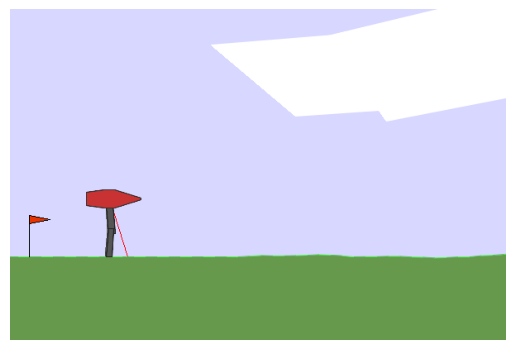

In [4]:
env = rld.make("rldurham/Walker", render_mode="rgb_array")
# env = rld.make("rldurham/Walker", render_mode="rgb_array", hardcore=True) # only attempt this when your agent has solved the non-hardcore version

# get statistics, logs, and videos
env = rld.Recorder(
    env,
    smoothing=10,                       # track rolling averages (useful for plotting)
    video=True,                         # enable recording videos
    video_folder="videos",              # folder for videos
    video_prefix="lspf78-agent-video",  # prefix for videos (replace lspf78 with your username)
    logs=True,                          # keep logs
)

# training on CPU recommended
rld.check_device()

# environment info
rld.env_info(env, print_out=True)

# render start image (reset just to render image)
env.reset(seed=42)
rld.render(env)

**Collect episodes and train the agent**

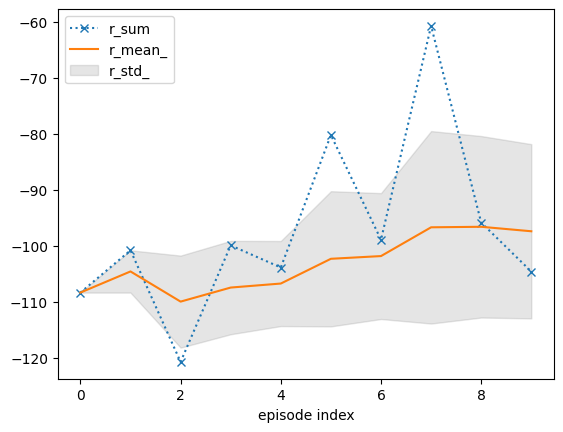

In [5]:
# in the submission please use seed_everything with seed 42 for verification
seed, observation, info = rld.seed_everything(42, env)

# initialise agent
agent = Agent(env)
max_episodes = 10

# track statistics for plotting
tracker = rld.InfoTracker()

# switch video recording off (only switch on every x episodes as this is slow)
env.video = False

# training procedure
for episode in range(max_episodes):
    
    # recording statistics and video can be switched on and off (video recording is slow!)
    env.info = True                 # usually tracking every episode is fine
    env.video = episode % 100 == 0  # record videos every 100 episodes (set BEFORE calling reset!)

    # reset for new episode
    observation, info = env.reset()

    # run episode
    done = False
    while not done:
        
        # select the agent action
        action = agent.sample_action(observation)

        # take action in the environment
        observation, reward, terminated, truncated, info = env.step(action)

        # remember
        agent.put_data(action, observation, reward)

        # check whether done
        done = terminated or truncated

    # train the agent after each episode
    agent.train()
            
    # track and plot statistics
    tracker.track(info)
    if (episode + 1) % 10 == 0:
        tracker.plot(r_mean_=True, r_std_=True, r_sum=dict(linestyle=':', marker='x'))

# don't forget to close environment (e.g. triggers last video save)
env.close()

# write log file (for coursework)
env.write_log(folder="logs", file="xxxx00-agent-log.txt")  # replace xxxx00 with your username

## Heuristic demo

A small demo with a predefined heuristic that is suboptimal and has no notion of balance (designed for the orignal BipedalWalker environment, but should also work fine for rldurham/Walker).

In [6]:
from gymnasium.envs.box2d.bipedal_walker import BipedalWalkerHeuristics

env = rld.make(
    "rldurham/Walker",
    # "BipedalWalker-v3",
    render_mode="human",
    # render_mode="rgb_array",
    hardcore=False,
    # hardcore=True,
)
_, obs, info = rld.seed_everything(42, env)

heuristics = BipedalWalkerHeuristics()

act = heuristics.step_heuristic(obs)
for _ in range(500):
    obs, rew, terminated, truncated, info = env.step(act)
    act = heuristics.step_heuristic(obs)
    if terminated or truncated:
        break
    if env.render_mode == "rgb_array":
        rld.render(env, clear=True)
env.close()

Seed set to 42


## TD3 Implementation

This section replaces the SAC baseline with **TD3 (Twin Delayed DDPG)**, a strong off-policy algorithm for **continuous** control.

Key TD3 ideas (compared to DDPG):

- **Twin critics** \(Q_1, Q_2\) and use \(\min(Q_1, Q_2)\) for targets to reduce overestimation.
- **Target policy smoothing**: add clipped noise to the *target* action when computing the bootstrap target.
- **Delayed policy updates**: update the actor (policy) less frequently than the critics for stability.
- **Soft target updates** (Polyak averaging) for both actor and critics.

The implementation below is intentionally compact and easy to tune for the coursework.


In [7]:

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass


# -----------------------------
# Replay Buffer
# -----------------------------
class ReplayBuffer:
    def __init__(self, obs_dim: int, act_dim: int, size: int = 1_000_000):
        self.obs_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.obs2_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros((size, act_dim), dtype=np.float32)
        self.rew_buf = np.zeros((size, 1), dtype=np.float32)
        self.done_buf = np.zeros((size, 1), dtype=np.float32)
        self.max_size = size
        self.ptr = 0
        self.size = 0

    def store(self, obs, act, rew, obs2, done):
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.obs2_buf[self.ptr] = obs2
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self, batch_size: int, device: torch.device):
        idxs = np.random.randint(0, self.size, size=batch_size)
        return dict(
            obs=torch.as_tensor(self.obs_buf[idxs], device=device),
            act=torch.as_tensor(self.act_buf[idxs], device=device),
            rew=torch.as_tensor(self.rew_buf[idxs], device=device),
            obs2=torch.as_tensor(self.obs2_buf[idxs], device=device),
            done=torch.as_tensor(self.done_buf[idxs], device=device),
        )


# -----------------------------
# Networks
# -----------------------------
def mlp(sizes, activation=nn.ReLU, output_activation=nn.Identity):
    layers = []
    for j in range(len(sizes) - 1):
        act = activation if j < len(sizes) - 2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j + 1]), act()]
    return nn.Sequential(*layers)


class Actor(nn.Module):
    def __init__(self, obs_dim: int, act_dim: int, act_limit: np.ndarray):
        super().__init__()
        self.net = mlp([obs_dim, 256, 256, act_dim], activation=nn.ReLU, output_activation=nn.Tanh)
        self.register_buffer("act_limit", torch.as_tensor(act_limit, dtype=torch.float32))

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        return self.net(obs) * self.act_limit


class CriticTwin(nn.Module):
    # Two Q networks in one module
    def __init__(self, obs_dim: int, act_dim: int):
        super().__init__()
        self.q1 = mlp([obs_dim + act_dim, 256, 256, 1], activation=nn.ReLU)
        self.q2 = mlp([obs_dim + act_dim, 256, 256, 1], activation=nn.ReLU)

    def forward(self, obs: torch.Tensor, act: torch.Tensor):
        x = torch.cat([obs, act], dim=-1)
        return self.q1(x), self.q2(x)

    def q1_only(self, obs: torch.Tensor, act: torch.Tensor):
        x = torch.cat([obs, act], dim=-1)
        return self.q1(x)


# -----------------------------
# TD3 Agent
# -----------------------------
@dataclass
class TD3Config:
    gamma: float = 0.99
    tau: float = 0.005
    actor_lr: float = 1e-3
    critic_lr: float = 1e-3

    buffer_size: int = 500_000
    batch_size: int = 256

    # exploration (interaction) noise
    exploration_noise: float = 0.1

    # target policy smoothing noise
    policy_noise: float = 0.2
    noise_clip: float = 0.5

    # delayed policy update
    policy_delay: int = 2

    # warmup steps of random actions
    start_steps: int = 5_000

    # how many gradient steps per environment step (can tune)
    update_every: int = 1
    gradient_steps: int = 1


class TD3Agent(nn.Module):
    def __init__(self, env, cfg: TD3Config = TD3Config(), device: str = "cpu"):
        super().__init__()
        self.cfg = cfg
        self.device = torch.device(device)

        # environment dims
        self.discrete_act, self.discrete_obs, self.act_dim, self.obs_dim = rld.env_info(env)
        assert not self.discrete_act and not self.discrete_obs, "This TD3 assumes continuous actions and observations."

        # action scaling (handles non-[-1,1] ranges)
        self.act_limit = env.action_space.high.astype(np.float32)

        # networks
        self.actor = Actor(self.obs_dim, self.act_dim, self.act_limit).to(self.device)
        self.actor_targ = Actor(self.obs_dim, self.act_dim, self.act_limit).to(self.device)
        self.critic = CriticTwin(self.obs_dim, self.act_dim).to(self.device)
        self.critic_targ = CriticTwin(self.obs_dim, self.act_dim).to(self.device)

        self.actor_targ.load_state_dict(self.actor.state_dict())
        self.critic_targ.load_state_dict(self.critic.state_dict())

        self.actor_opt = torch.optim.Adam(self.actor.parameters(), lr=self.cfg.actor_lr)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=self.cfg.critic_lr)

        self.replay = ReplayBuffer(self.obs_dim, self.act_dim, size=self.cfg.buffer_size)

        self.total_steps = 0
        self.update_steps = 0

    @torch.no_grad()
    def select_action(self, obs: np.ndarray, explore: bool = True) -> np.ndarray:
        self.total_steps += 1

        # warmup: random actions
        if explore and self.total_steps < self.cfg.start_steps:
            return np.random.uniform(-self.act_limit, self.act_limit).astype(np.float32)

        obs_t = torch.as_tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)
        act = self.actor(obs_t).cpu().numpy()[0]

        if explore:
            act += np.random.normal(0, self.cfg.exploration_noise, size=self.act_dim).astype(np.float32) * self.act_limit

        return np.clip(act, -self.act_limit, self.act_limit).astype(np.float32)

    def store(self, obs, act, rew, obs2, done):
        self.replay.store(obs, act, np.float32(rew), obs2, np.float32(done))

    def _soft_update(self, net, net_targ):
        tau = self.cfg.tau
        with torch.no_grad():
            for p, p_targ in zip(net.parameters(), net_targ.parameters()):
                p_targ.data.mul_(1 - tau)
                p_targ.data.add_(tau * p.data)

    def train_step(self):
        if self.replay.size < max(self.cfg.batch_size, 1_000):
            return

        for _ in range(self.cfg.gradient_steps):
            batch = self.replay.sample_batch(self.cfg.batch_size, self.device)
            obs, act, rew, obs2, done = batch["obs"], batch["act"], batch["rew"], batch["obs2"], batch["done"]

            with torch.no_grad():
                # target policy smoothing
                noise = torch.randn_like(act) * self.cfg.policy_noise
                noise = torch.clamp(noise, -self.cfg.noise_clip, self.cfg.noise_clip)
                noise = noise * self.actor.act_limit  # scale by action limits

                act2 = self.actor_targ(obs2)
                act2 = torch.clamp(act2 + noise, -self.actor.act_limit, self.actor.act_limit)

                q1_t, q2_t = self.critic_targ(obs2, act2)
                q_t = torch.min(q1_t, q2_t)
                backup = rew + self.cfg.gamma * (1.0 - done) * q_t

            # critic update
            q1, q2 = self.critic(obs, act)
            critic_loss = F.mse_loss(q1, backup) + F.mse_loss(q2, backup)

            self.critic_opt.zero_grad()
            critic_loss.backward()
            self.critic_opt.step()

            # delayed actor update
            if self.update_steps % self.cfg.policy_delay == 0:
                actor_loss = -self.critic.q1_only(obs, self.actor(obs)).mean()

                self.actor_opt.zero_grad()
                actor_loss.backward()
                self.actor_opt.step()

                self._soft_update(self.actor, self.actor_targ)
                self._soft_update(self.critic, self.critic_targ)

            self.update_steps += 1

    def episode(self, env, max_steps: int = 1000):
        obs, info = env.reset()
        done = False
        ep_ret = 0.0
        ep_len = 0

        while not done and ep_len < max_steps:
            act = self.select_action(obs, explore=True)
            obs2, rew, terminated, truncated, info = env.step(act)
            done = terminated or truncated

            self.store(obs, act, rew, obs2, float(done))
            obs = obs2

            ep_ret += float(rew)
            ep_len += 1

            if self.total_steps % self.cfg.update_every == 0:
                self.train_step()

        info = dict(info) if isinstance(info, dict) else {}
        info.setdefault("r_sum", ep_ret)
        info.setdefault("t", ep_len)
        return info


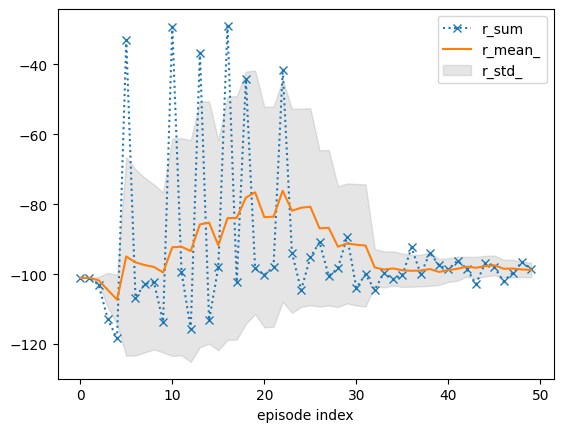

KeyboardInterrupt: 

In [8]:

# initialise environment
env = rld.make("rldurham/Walker", render_mode="rgb_array")
rld.seed_everything(42, env)

# set up recording
env = rld.Recorder(env, smoothing=10, video=True)
recorder = env
recorder.video = False
tracker = rld.InfoTracker()

# clip negative rewards (known trick in Walker environment)
env = rld.transparent_wrapper(gym.wrappers.ClipReward)(env, min_reward=-10)

# initialise TD3 agent (feel free to tune the config)
cfg = TD3Config(
    gamma=0.99,
    tau=0.005,
    actor_lr=1e-3,
    critic_lr=1e-3,
    buffer_size=500_000,
    batch_size=256,
    exploration_noise=0.1,
    policy_noise=0.2,
    noise_clip=0.5,
    policy_delay=2,
    start_steps=5_000,
    update_every=1,
    gradient_steps=1,
)
agent = TD3Agent(env, cfg=cfg, device="cpu")

for n_epi in range(1000):

    recorder.video = (n_epi + 1) % 100 == 0   # record video every 100 episodes
    info = agent.episode(env)                 # collect one episode (+ train along the way)
    env.add_stats(info, ignore_existing=True) # explicitly add stats in case of early termination
    tracker.track(info)                       # track statistics

    # update progress every 10 episodes
    if (n_epi + 1) % 10 == 0:
        tracker.plot(r_mean_=True, r_std_=True, r_sum=dict(linestyle=':', marker='x'))

env.close()
